In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

### Plot Gaussian

In [30]:
from matplotlib.patches import Ellipse    
        
def plot_gaussian(mus, sigmas, weights = None):
    K = len(mus)
    if weights is None:
        weights = np.ones(K)/K
    fig, ax = plt.subplots()
    
    for k in range(len(mus)):
        sigma = sigmas[k]
        val,vec = np.linalg.eig(sigma)
        angle = np.arctan2(vec[0,1], vec[0,0])
        ells = Ellipse(xy=mus[k],
                width=3.*np.sqrt(val[0]), height=3.*np.sqrt(val[1]),
                angle=np.rad2deg(angle))
        #ells.set_clip_box(a.bbox)
        ells.set_alpha(weights[k])
        ax.add_artist(ells)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    return

### Generate Data

IndexError: index 1 is out of bounds for axis 1 with size 1

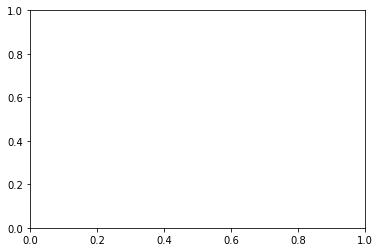

In [590]:
D = 2
mu1 = np.array([3., -4.])
sigma1 = np.diag([1., 5.])

mu2 = np.array([-3., -3.])
sigma2 = np.diag([4., 1.])

N = 100

sample1 = np.random.multivariate_normal(mu1, cov = sigma1, size = N/2)
sample2 = np.random.multivariate_normal(mu2, cov = sigma2, size = N/2)
samples = np.vstack([sample1, sample2])
plot_gaussian([mu1,mu2],[sigma1,sigma2])
plt.plot(sample1[:,0],sample1[:,1],'*')
plt.plot(sample2[:,0],sample2[:,1],'*')


### Gaussian Mixture Model

In [315]:
import time

In [319]:
K = 3
pis = np.ones(K)/K
mus = np.random.rand(K,D)
sigmas = np.array([np.eye(D) for i in range(K)])
zs = np.zeros((N,K))

[[-3.4927687  -2.99636213]
 [-2.14655485 -3.20848155]
 [ 3.04003302 -3.89524721]]


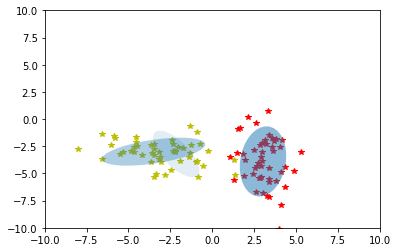

In [320]:
from IPython.display import clear_output
for j in range(20):    
    ###  E-Step
    for i in range(N):
        for k in range(K):
            zs[i,k] = pis[k]*mvn.pdf(samples[i,:],mus[k], sigmas[k])

        zs[i,:] = zs[i,:]/np.sum(zs[i,:])
    Ns = np.sum(zs,axis=0)

    ### M-Step
    for k in range(K):
        mus[k,:] = np.dot(zs[:,k].T, samples)/Ns[k]
        sigma_k = np.zeros((D,D))
        for i in range(N):
            sigma_k += zs[i,k]*np.outer(samples[i,:]-mus[k,:], samples[i,:].T-mus[k,:].T)
        sigma_k /= Ns[k]
        sigmas[k,:] = sigma_k
        pis[k] = Ns[k]/N 
    print mus
    
    plot_gaussian(mus,sigmas,pis)
    plt.plot(sample1[:,0],sample1[:,1],'r*',zorder = 0)
    plt.plot(sample2[:,0],sample2[:,1],'y*',zorder = 0)
    plt.show()
    #raw_input()
    clear_output(wait=True)
    
    time.sleep(0.1)


### Bayesian Gaussian Mixture 

In [287]:
from sklearn.mixture import BayesianGaussianMixture

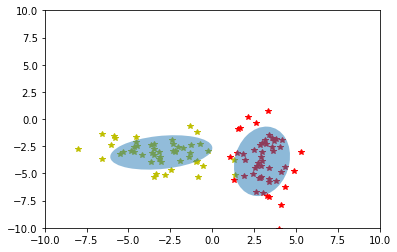

In [322]:
bgmm = BayesianGaussianMixture(n_components=4, n_init=5)
bgmm.fit(samples)
plot_gaussian(bgmm.means_, bgmm.covariances_, bgmm.weights_)
plt.plot(sample1[:,0],sample1[:,1],'r*',zorder = 0)
plt.plot(sample2[:,0],sample2[:,1],'y*',zorder = 0)

### Implement different techniques: MCMC sampling, Laplace Approximations, and Gaussian Variational Approximations 

(array([ 4., 10., 11., 25., 19., 14.,  8.,  7.,  0.,  2.]),
 array([-7.11232597, -6.074702  , -5.03707802, -3.99945405, -2.96183008,
        -1.92420611, -0.88658213,  0.15104184,  1.18866581,  2.22628979,
         3.26391376]),
 <a list of 10 Patch objects>)

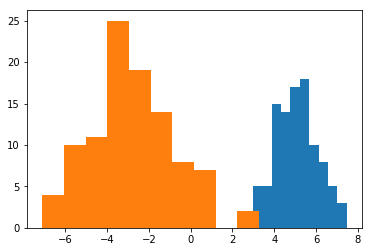

In [609]:
D = 1
K = 2
mu1 = np.array([5.])
sigma1 = np.diag([1.])

mu2 = np.array([-3.])
sigma2 = np.diag([4.])

N = 200

sample1 = np.random.multivariate_normal(mu1, cov = sigma1, size = N/2)
sample2 = np.random.multivariate_normal(mu2, cov = sigma2, size = N/2)
samples = np.vstack([sample1, sample2])
#plot_gaussian([mu1,mu2],[sigma1,sigma2])
plt.hist(sample1)
plt.hist(sample2)


In [664]:
from scipy.stats import multivariate_normal as mvn
from scipy.stats import dirichlet, invwishart, wishart

In [666]:
def log_gaussian_prior(mu_0 = np.zeros(D), sigma_0 = np.eye(D)):
    func = lambda mu: mvn.logpdf(mu, mean=mu_0, cov = sigma_0)
    return func
    
def log_dirichlet_prior(alphas = np.ones(K)/K):
    def func( pis):
        return dirichlet.logpdf(pis, alphas)
    return func
    
def log_wishart_prior(df = D, scale = np.eye(D)):
    func = lambda sigma: wishart.logpdf(sigma, df, scale)
    return func

In [667]:
def log_joint_prior():
    log_prior_mu  = log_gaussian_prior()
    log_prior_pis = log_dirichlet_prior()
    log_prior_sigma = log_wishart_prior()
    func = lambda mus, sigmas, pis: np.sum([log_prior_mu(mu) for mu in mus]) + log_prior_pis(pis) + np.sum([log_prior_sigma(sigma) for sigma in sigmas])
    return func

def log_likelihood(x):
    func = lambda mus, sigmas, pis: np.log(np.sum([pis[k]*mvn.pdf(x, mus[k], sigmas[k]) for k in range(len(pis))]))
    return func
    
def log_posterior(data):
    log_prior = log_joint_prior()
    
    def func(theta):
        mus, sigmas, pis = theta[0], theta[1], theta[2]
        val = log_prior(mus, sigmas, pis)
        
        for x in data:
            log_likelihood_datapoint = log_likelihood(x)
            val+= log_likelihood_datapoint(mus, sigmas, pis)
        
        return val
    
    return func

### Plotting the cross-section of the posteriors

In [668]:
sigmas_true = np.array([sigma1, sigma2])
mus_true = np.array([mu1, mu2])
pis_true = np.array([0.5, 0.5])

log_posterior_data = log_posterior(samples)

#### Posterior of Pis 

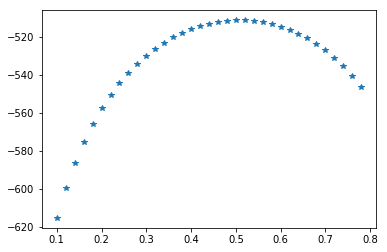

In [669]:
pis_proposal = np.arange(0.1,0.8,0.02)
post = []
for pis in pis_proposal:
    pis = np.array([pis, 1-pis])
    post.append(log_posterior_data([mus_true, sigmas_true, pis]))
    
plt.plot(pis_proposal, post, '*')

#### Posterior of Mus 

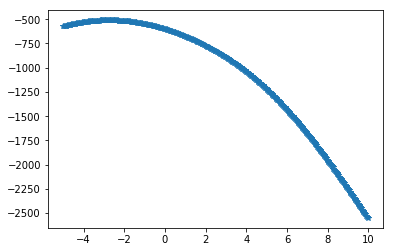

In [670]:
mus_proposal = np.arange(-5,10,0.04)
post = []
for mu in mus_proposal:
    mus = np.array([mu1,mu])
    post.append(log_posterior_data([mus, sigmas_true, pis_true]))
    
plt.plot(mus_proposal, post, '*')

#### Posterior of Sigmas 

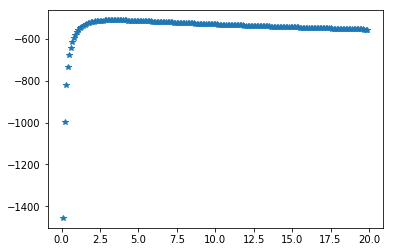

In [674]:
sigmas_proposal = np.arange(0.1,20,0.1)
post = []
for sigma in sigmas_proposal:
    sigmas = np.array([sigma1,np.array([[sigma]])])
    post.append(log_posterior_data([mus_true, sigmas, pis_true]))
    
plt.plot(sigmas_proposal, post, '*')

In [660]:
print sigma1,sigma2

[[1.]] [[4.]]


In [675]:
sigmas_proposal[np.argmax(post)]

3.4000000000000004

In [920]:
def random_move(theta, lamda = 0.05):
    mus, sigmas, pis = np.copy(theta[0]), np.copy(theta[1]), np.copy(theta[2])
    for k in range(len(mus)):
        delta_mu = lamda*mvn.rvs(mean=np.zeros(D))
        mus[k] += delta_mu
        
        delta_sigma = lamda*wishart.rvs(df = 5., scale = sigmas[k]/5.)
        sigmas[k] += delta_sigma
        
        delta_pis = lamda*dirichlet.rvs(np.ones(K)/K).flatten()
        pis += delta_pis
    
    pis = pis / np.sum(pis)
    
    return [mus, sigmas, pis]

### Do MCMC on the unnormalized posterior

In [921]:
def MH_sampling(func,theta0, n = 1000, lamda= 0.05):
    samples = [theta0]
    cur_theta = theta0
    accept_num = 0
    for i in range(n):
        cur_func_value = func(cur_theta)
        #Proposal distribution
        new_theta = random_move(cur_theta,lamda)
        print new_theta[1]
        new_func_value = func(new_theta)
        print new_func_value
        #decide whether to accept or reject
        accept_threshold = np.exp(new_func_value-cur_func_value)
        print accept_threshold
        random_num = np.random.rand()
        if random_num < accept_threshold: #equivalent to the above
            samples.append(new_theta)
            cur_theta = new_theta
            accept_num += 1
        else:
            samples.append(cur_theta)
    
    return (samples), 1.0*accept_num/n

In [922]:
print theta0[1]
print log_posterior_data(theta0)
new_theta = random_move(theta0,0.2)
print new_theta[1]
print log_posterior_data(new_theta)
np.exp(log_posterior_data(new_theta)-log_posterior_data(theta0))

[[[1.]]

 [[4.]]]
-887.4775990752548
[[[0.00229722]]

 [[0.00274965]]]
-inf


/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


0.0

In [906]:
sigmas_true = np.array([sigma1, sigma2])
mus_true = np.array([2., -1])
pis_true = np.array([0.1, 0.9])
theta0 = [mus_true, sigmas_true, pis_true]
print pis_true

[0.1 0.9]


In [764]:
from IPython.display import clear_output

In [762]:
posterior_samples, success_rate = MH_sampling(log_posterior_data, theta0, n = 200, lamda = 0.1)
clear_output()
print success_rate

[[0.1061291]]
[[0.42918552]]
[[[0.1061291 ]]

 [[0.42918552]]]
0.0
[[0.09947431]]
[[0.39929862]]
[[[0.09947431]]

 [[0.39929862]]]
0.0
[[0.0982975]]
[[0.41668507]]
[[[0.0982975 ]]

 [[0.41668507]]]
0.0
[[0.10340505]]
[[0.4097042]]
[[[0.10340505]]

 [[0.4097042 ]]]
0.0
[[0.09959079]]
[[0.37214351]]
[[[0.09959079]]

 [[0.37214351]]]
0.0
[[0.09365485]]
[[0.40024512]]
[[[0.09365485]]

 [[0.40024512]]]
0.0
[[0.09854152]]
[[0.38190564]]
[[[0.09854152]]

 [[0.38190564]]]
0.0
[[0.10037256]]
[[0.41461621]]
[[[0.10037256]]

 [[0.41461621]]]
0.0
[[0.09655092]]
[[0.37502258]]
[[[0.09655092]]

 [[0.37502258]]]
0.0
[[0.09633042]]
[[0.3825253]]
[[[0.09633042]]

 [[0.3825253 ]]]
0.0
[[0.10575507]]
[[0.3671858]]
[[[0.10575507]]

 [[0.3671858 ]]]
0.0
[[0.10031919]]
[[0.41854253]]
[[[0.10031919]]

 [[0.41854253]]]
0.0
[[0.10245691]]
[[0.3982479]]
[[[0.10245691]]

 [[0.3982479 ]]]
0.0
[[0.09662128]]
[[0.42555147]]
[[[0.09662128]]

 [[0.42555147]]]
0.0
[[0.09482088]]
[[0.39981658]]
[[[0.09482088]]

 [[0.39

[[0.09984558]]
[[0.42682334]]
[[[0.09984558]]

 [[0.42682334]]]
0.0
[[0.09277481]]
[[0.38583641]]
[[[0.09277481]]

 [[0.38583641]]]
0.0
[[0.08569728]]
[[0.43575798]]
[[[0.08569728]]

 [[0.43575798]]]
0.0
[[0.09860857]]
[[0.40631697]]
[[[0.09860857]]

 [[0.40631697]]]
0.0
[[0.10521146]]
[[0.3468766]]
[[[0.10521146]]

 [[0.3468766 ]]]
0.0
[[0.09604288]]
[[0.39713564]]
[[[0.09604288]]

 [[0.39713564]]]
0.0
[[0.09801205]]
[[0.38828377]]
[[[0.09801205]]

 [[0.38828377]]]
0.0
[[0.09499196]]
[[0.41281526]]
[[[0.09499196]]

 [[0.41281526]]]
0.0
[[0.0959937]]
[[0.38117279]]
[[[0.0959937 ]]

 [[0.38117279]]]
0.0
[[0.09670101]]
[[0.42205886]]
[[[0.09670101]]

 [[0.42205886]]]
0.0
[[0.09881761]]
[[0.42631638]]
[[[0.09881761]]

 [[0.42631638]]]
0.0
[[0.09696115]]
[[0.41809608]]
[[[0.09696115]]

 [[0.41809608]]]
0.0
[[0.09935906]]
[[0.38299573]]
[[[0.09935906]]

 [[0.38299573]]]
0.0
[[0.10105195]]
[[0.38454895]]
[[[0.10105195]]

 [[0.38454895]]]
0.0
[[0.10570404]]
[[0.42632179]]
[[[0.10570404]]

 [[

In [747]:
samples_mus = []
samples_sigmas = []
samples_pis = []

for sample in posterior_samples:
    samples_mus.append(sample[0])
    samples_sigmas.append(sample[1])
    samples_pis.append(sample[2])

In [748]:
np.mean(np.array(samples_mus), axis=0)

array([ 4.50528107, -2.20320766])

In [749]:
np.mean(np.array(samples_sigmas), axis=0)

array([[[1.]],

       [[4.]]])

0.0

In [751]:
np.mean(np.array(samples_pis), axis=0)

array([0.47344221, 0.52655779])

In [752]:
print mu1, mu2

[5.] [-3.]


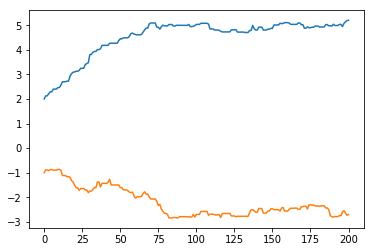

In [753]:
plt.plot(samples_mus)

In [690]:
samples_sigmas[0].shape

(2, 1, 1)